# Libaries and Requirements

In [108]:
library(reticulate)
library(tensorflow)
library(keras)
install.packages("tfprobability")
install_tensorflow(extra_packages = "tensorflow-probability")
install_tensorflow(version = "nightly")
library(tfprobability)
print('---')
install.packages("corrr")
library(tidymodels) # for readability 
library(data.table) # for speed on data frames
library(ggplot2) # visualizations
library(readr)
library(skimr) # to get a fast grasp of the dataset 
library(GGally)
library(purrr) # for fast plotting multiple ggplots
library(patchwork) # for allocating multiple ggplots easily
library(corrr)
library(corrplot)
library(rlang) # for creating functions of ggplots
print(0)
# library(mltools)
# library(neuralnet)
# library("ggpubr")
# library(ggcorrplot)
# library(gridExtra)
# library(ggridges)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Using virtual environment '/usr/local/share/.virtualenvs/r-reticulate' ...

Installation complete.

Using virtual environment '/usr/local/share/.virtualenvs/r-reticulate' ...

Installation complete.

[1] "---"


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] 0


# Dataset and basic exploration

In [109]:
library(readr)
library(data.table) # for speed on data frames
wine <- as.data.table(read_csv("../input/wine-data/wine.csv"))
skim(wine)



── Column specification ────────────────────────────────────────────────────────
cols(
  fixed.acidity = col_double(),
  volatile.acidity = col_double(),
  citric.acid = col_double(),
  residual.sugar = col_double(),
  chlorides = col_double(),
  free.sulfur.dioxide = col_double(),
  total.sulfur.dioxide = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  type = col_double()
)




── Data Summary ────────────────────────
                           Values
Name                       wine  
Number of rows             4898  
Number of columns          13    
_______________________          
Column type frequency:           
  numeric                  13    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable        n_missing complete_rate     mean       sd    p0     p25
 1 fixed.acidity                0             1   6.85    0.844   3.8     6.3  
 2 volatile.acidity             0             1   0.278   0.101   0.08    0.21 
 3 citric.acid                  0             1   0.334   0.121   0       0.27 
 4 residual.sugar               0             1   6.39    5.07    0.6     1.7  
 5 chlorides                    0             1   0.0458  0.0218  0.009   0.036
 6 free.sulfur.dioxide          0             1  35.3    17.0     2      23    
 7 total.su

* No missing values
* Vastly different scales - needs scaling
* Mostly numeric with two factor type features (type and quality)

# PCA for explainability

In [110]:
library(broom)
library(tidytext)

#remove target
wine.X <- wine %>% select(-quality)
wine.y <- wine %>% select(quality)

# center and decompose
wine.cntr.X <- t(t(wine.X) - colMeans(wine.X))
svd.results <- svd(wine.cntr.X)

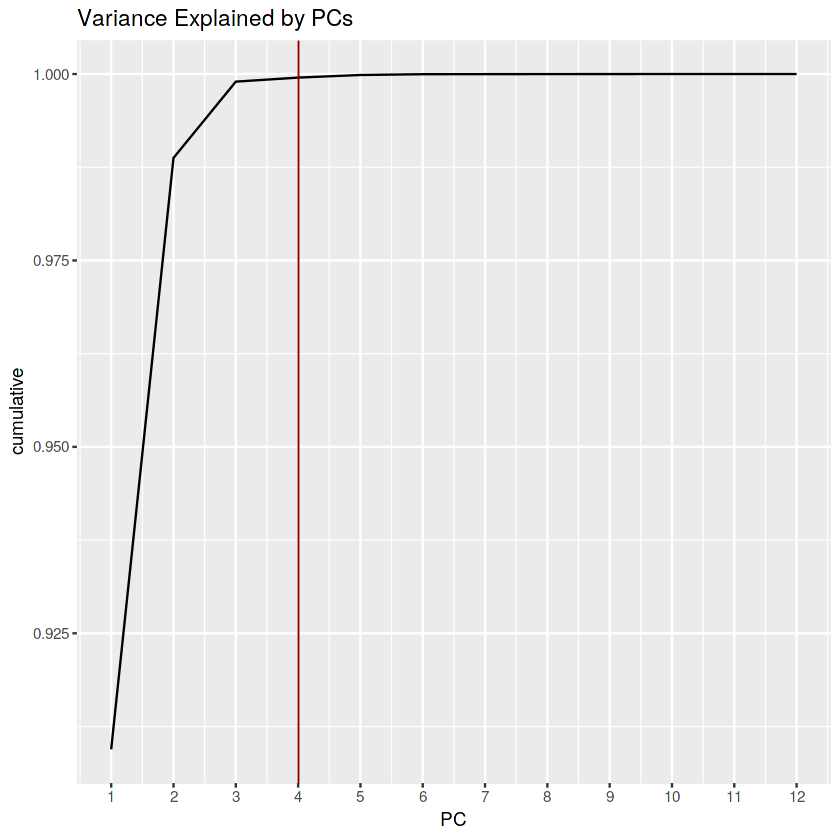

In [111]:
# interpret variance explained 
svd.var.exp <- tidy(svd.results, matrix="d")

svd.var.exp %>% ggplot(aes(x=PC, cumulative)) + 
                geom_line() + 
                geom_vline(xintercept = 4, color = "red4", size=0.4) +
                scale_x_continuous(breaks = seq(min(svd.var.exp$PC),max(svd.var.exp$PC),by=1)) +
                coord_cartesian(xlim=c(1,12)) +
                labs(title = "Variance Explained by PCs")

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



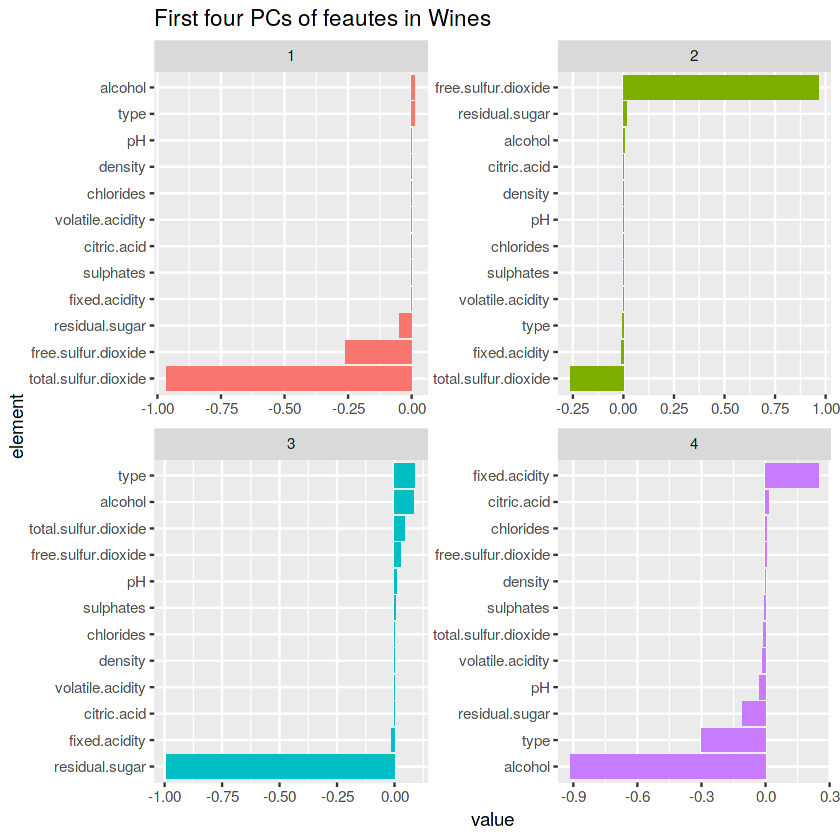

In [112]:
# interpret loadings - working on columns
svd.loadings <- tidy(svd.results, matrix="v") %>%
                mutate(element = colnames(wine.cntr.X)[column])

svd.loadings %>% filter(PC<=4) %>%
                 group_by(PC) %>%
                 top_n(12, abs(value)) %>%
                 ungroup() %>%
                 mutate(element = reorder_within(element, value, PC)) %>%
                 ggplot(aes(x=element, y=value, fill=factor(PC))) +
                 geom_col(show.legend = FALSE) +
                 facet_wrap(~PC, scales="free") +
                 scale_x_reordered() + 
                 coord_flip() +
                 labs(title = "First four PCs of feautes in Wines")

* PC1: alcohol vs sulfur (total.sulfur.dioxide)
* PC2: total.surfure.dioxide vs free.surfuredioxide
* PC3: alcohol vs residual.sugar
* PC4: fixed.acidity vs alcohol

The variance is explained by:
alcohol degrees vs bad smells, then by the distinction of free and total sulfur. 
Afterwards, the precentage of alcohol degrees compared to the residual sugar and lastly 
by distinguishing between acidity and alcohol. So in summary:
1. Alcohol vs unpleasant oddors
2. Where the unpleasant oddors are coming from
3. Alcohol vs sweatness 
4. Alcohol vs acidity

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



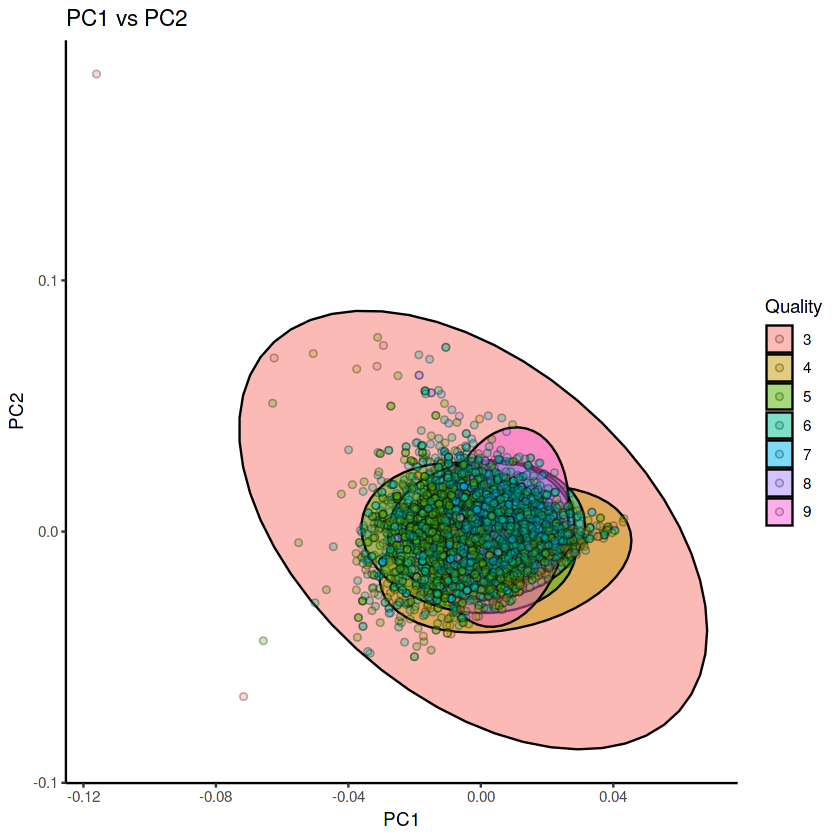

In [113]:
# final plot
svd.pcs <- tidy(svd.results, matrix="u") 

svd.pcs.1 <- svd.pcs %>% filter(PC==1) %>%
             mutate(PC1=value) %>%
             select(PC1)
svd.pcs.2 <- svd.pcs %>% filter(PC==2) %>%
             mutate(PC2=value) %>%
             select(PC2)
svd.pcs.3 <- svd.pcs %>% filter(PC==3) %>%
             mutate(PC3=value) %>%
             select(PC3)
wine.pcs <- cbind(wine.y, svd.pcs.1, svd.pcs.2, svd.pcs.3)

wine.pcs %>%
ggplot(aes(x=PC1, y=PC2, col=quality, fill=factor(quality))) + 
stat_ellipse(geom="polygon", col="black", alpha=0.5) + 
geom_point(shape=21, col="black", alpha=0.3) +
# stat_binhex() +
labs(title = "PC1 vs PC2", fill="Quality") +
theme_classic()

In [114]:
# 3d plot of PCA no better results
# library(plotly)
# temp <- wine.pcs$PC1
# pressure <- wine.pcs$PC2
# dtime <- wine.pcs$PC3
# gr <- factor(wine.pcs$quality)
# plot_ly(x=temp, y=pressure, z=dtime, type="scatter3d", mode="markers", color=gr)

# Univariate Analysis

In [115]:
plot.univariate <- function(var, density, dat=wine){
    
    if(var=="quality"){
        density=FALSE
        color="darkorange3"
    } else if(var=="type"){
        density=FALSE
        color="blue4"
    } else {
        density=TRUE
        color="blue4"
    }
        
    if(density){
        gg.var <- ggplot(data=wine, aes(x=.data[[var]])) +
        geom_density(col=color, fill=color, alpha=0.8) +
        scale_x_continuous() +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank()) + 
        ggtitle(var)
    } else {
        gg.var <- ggplot(data=wine, aes(x=.data[[var]])) +
        geom_histogram(col=color, fill=color, alpha=0.7, bins = 30) +
        scale_x_continuous() +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank()) + 
        ggtitle(var)
    }
    return(gg.var)
}

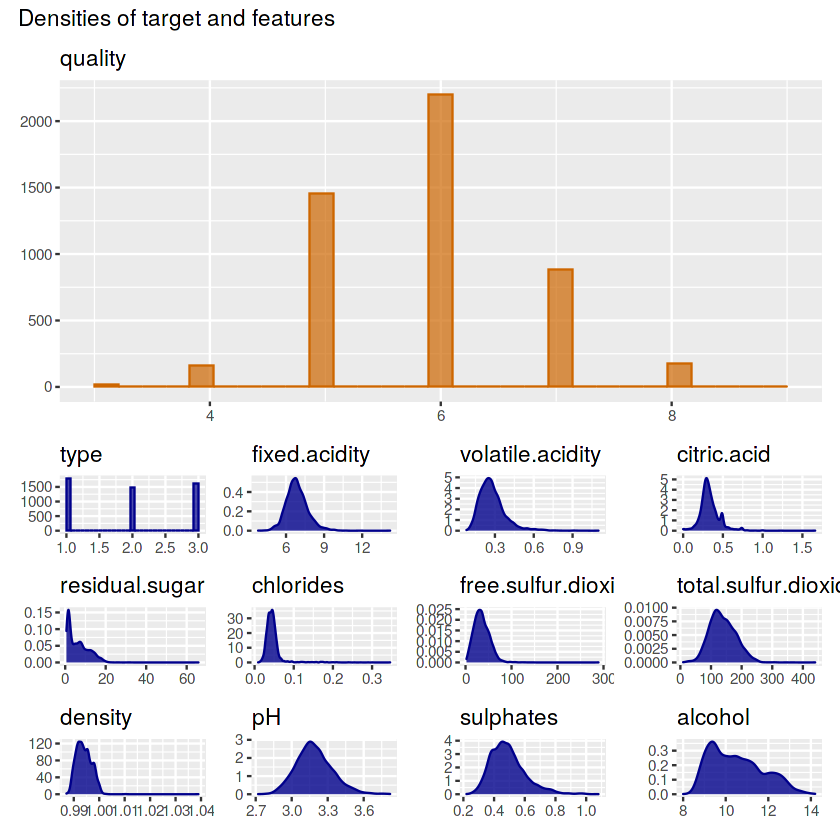

In [116]:
names <- names(wine)
names <- set_names(names)
plots <- map(names, ~plot.univariate(.x))
plots[[12]] + {
plots[[13]] + plots[[1]] + plots[[2]]  + plots[[3]]  +
plots[[4]]  + plots[[5]] + plots[[6]]  + plots[[7]]  +
plots[[8]]  + plots[[9]] + plots[[10]] + plots[[11]] + plot_layout(ncol=4, nrow=3)} + plot_layout(ncol=1) + plot_annotation(title='Densities of target and features')

# Bivariate Analysis

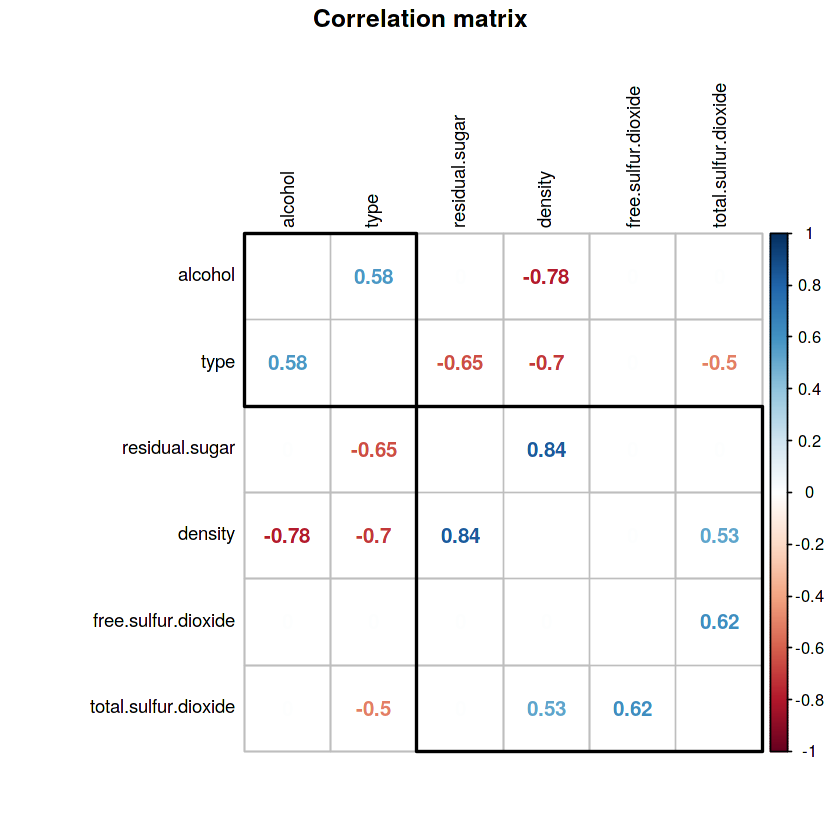

In [117]:
numcols <- sapply(wine, is.numeric) 
wine.corr <- wine[, ..numcols] %>% cor(use="pairwise.complete")
wine.corr.big <- wine.corr*(abs(wine.corr)>0.5)

wine.corr.big <- wine.corr.big[-which(abs(rowSums(wine.corr.big))==1),-which(abs(colSums(wine.corr.big))==1)]
square.cor <- corrplot(wine.corr.big,
                       order="hclust",
                       addrect=2,
                       method='number',
                       diag=FALSE,
                       tl.col="black",
                       tl.cex = 0.9,
                       outline=TRUE,
                       title="Correlation matrix",
                       cl.lim=c(-1, 1),
                       mar=c(0,0,1.5,0))


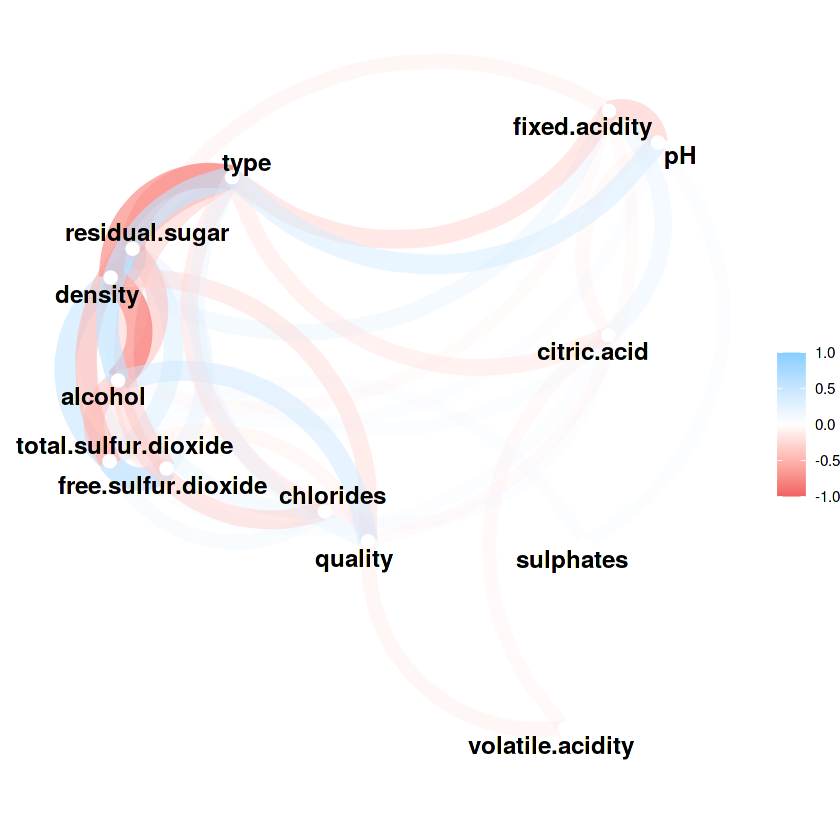

In [118]:
# Same information as aboce, different visualization
wine.corr <- as.data.frame(wine.corr)
wine.corr[wine.corr==1 ] <- NA
wine.corr %>% network_plot(min_cor=0.1)

# Multivariate Analysis

In [119]:
plot.multi <- function(dat, var1, var2, fct){
    
    gg.plot <- ggplot(data=dat, aes(x={{ var1 }}, y={{ var2 }}, col=factor( {{ fct }} ))) +
        geom_jitter(alpha=0.5) +
        facet_wrap(~factor({{fct}})) +
        geom_smooth(formula=y~x, method='lm') + 
        expand_limits(x=0, y=0) +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank(), 
              legend.position='none') + 
        ggtitle("Linear relation per quality bucket")
        return(gg.plot)
}

In [120]:
wrap_by <- function(...){
    # helper function to avoid an error!
    facet_wrap(vars(...))
}

plot.multi <- function(dat, var1, var2, fct){
    gg.plot <- ggplot(data=dat, aes(x={{ var1 }}, y={{ var2 }}, col={{ fct }} )) +
        geom_jitter(alpha=0.5) +
        wrap_by({{fct}}) + 
        geom_smooth(formula=y~x, method='lm') + 
        # expand_limits(x=0, y=0)  +
        theme(legend.position='none')
        return(gg.plot)
}

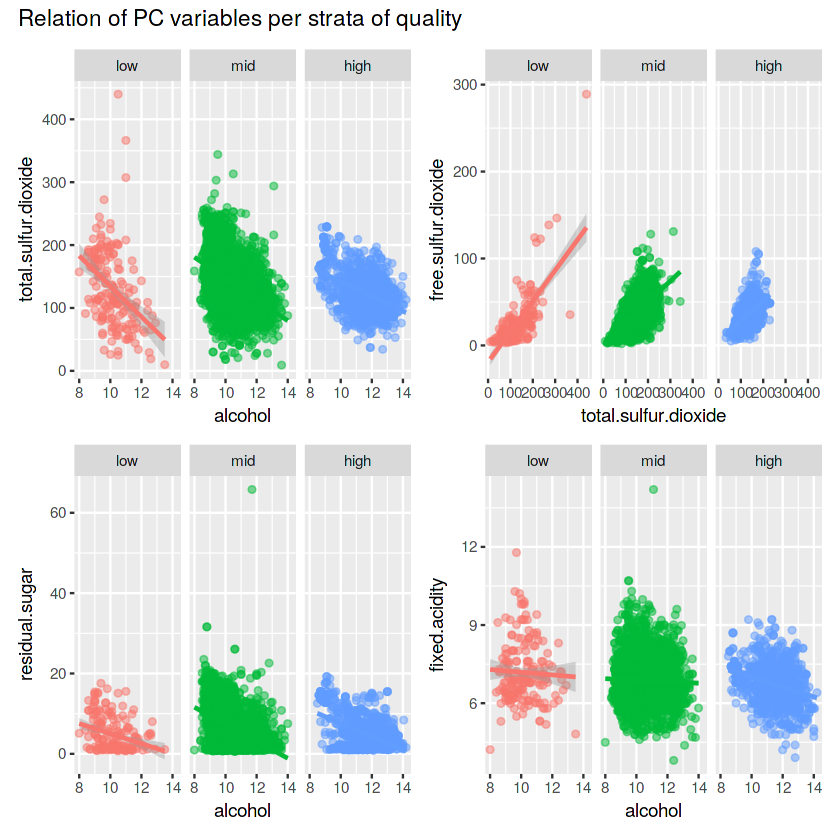

In [121]:
# group wine by quality and plot densities with the variables produced by PCA.
wine.multi <- wine %>% mutate(quality.bucket = case_when(
                    quality < 5 ~ "low",
                    quality < 7 ~ "mid",
                    TRUE ~ "high")) 

pc1.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=total.sulfur.dioxide,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc2.expl <- plot.multi(dat=wine.multi, var1=total.sulfur.dioxide, var2=free.sulfur.dioxide,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc3.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=residual.sugar,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc4.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=fixed.acidity,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc1.expl + pc2.expl + pc3.expl + pc4.expl + plot_layout(ncol=2, nrow=2) + plot_annotation(title='Relation of PC variables per strata of quality')

# Modeling

In [122]:
# Data splits
set.seed(1903)
wine.split <- initial_split(wine)
train.data <- training(wine.split)
test.data <- testing(wine.split)

X.full <- wine %>% select(-quality) %>% as.matrix()
X.train <- scale(train.data, center=TRUE, scale=TRUE) %>% as.data.frame(.) %>% select(-quality) %>% as.matrix()
X.test  <- test.data %>% select(-quality) %>% as.matrix()
y.full <- wine$quality
y.train <- train.data$quality 
y.test  <- test.data$quality

In [123]:
# Model Definition helper functions

## One hidden layer
fit.transform.1 <- function(input.shape=12, hidden.units=c(20), hidden.activation=c('relu'), hidden.rates=c(0), output.units=1, output.activation='relu',
                            X, Y, epochs, batch){
    # Model definition
    model <- keras_model_sequential(
    list(
        layer_input(shape=input.shape),
        layer_dense(units=hidden.units[1], activation=hidden.activation[1]),
        layer_dropout(rate=hidden.rates[1]),
        layer_dense(units=output.units, activation=output.activation)
        )
    )
    # Model compilation
    model %>% compile(optimizer=optimizer_adam(lr=0.01), loss='mse', metrics='mae')
    # Model fitting
    return(c(model))
}

## Two hidden layers
fit.transform.2 <- function(input.shape=12, hidden.units=c(20,20), hidden.activation=c('relu', 'relu'), hidden.rates=c(0, 0), output.units=1, output.activation='relu',
                            X, Y, epochs, batch){
    # Model definition
    model <- keras_model_sequential(
    list(
        layer_input(shape=input.shape),
        layer_dense(units=hidden.units[1], activation=hidden.activation[1]),
        layer_dropout(rate=hidden.rates[1]),
        layer_dense(units=hidden.units[2], activation=hidden.activation[2]),
        layer_dropout(rate=hidden.rates[2]),
        layer_dense(units=output.units, activation=output.activation)
        )
    )
    # Model compilation
    model %>% compile(optimizer=optimizer_adam(lr=0.01), loss='mse', metrics='mae')
    # Model fitting
    return(c(model))
}

## Three hidden layers
fit.transform.3 <- function(input.shape=12, hidden.units=c(20, 20 ,20), hidden.activation=c('relu', 'relu','relu'), hidden.rates=c(0, 0, 0), output.units=1, output.activation='relu',
                            X, Y, epochs, batch){
    # Model definition
    model <- keras_model_sequential(
    list(
        layer_input(shape=input.shape),
        layer_dense(units=hidden.units[1], activation=hidden.activation[1]),
        layer_dropout(rate=hidden.rates[1]),
        layer_dense(units=hidden.units[2], activation=hidden.activation[2]),
        layer_dropout(rate=hidden.rates[2]),
        layer_dense(units=hidden.units[3], activation=hidden.activation[3]),
        layer_dropout(rate=hidden.rates[3]),
        layer_dense(units=output.units, activation=output.activation)
        )
    )
    # Model compilation
    model %>% compile(optimizer=optimizer_adam(lr=0.01), loss='mse', metrics='mae')
    # Model fitting
    return(c(model))
}

## Four hidden layers
fit.transform.4 <- function(input.shape=12, hidden.units=c(20, 20 ,20, 20), hidden.activation=c('relu', 'relu','relu', 'relu'), hidden.rates=c(0, 0, 0, 0), output.units=1, output.activation='relu', 
                            X, Y, epochs, batch){
    # Model definition
    model <- keras_model_sequential(
    list(
        layer_input(shape=input.shape),
        layer_dense(units=hidden.units[1], activation=hidden.activation[1]),
        layer_dropout(rate=hidden.rates[1]),
        layer_dense(units=hidden.units[2], activation=hidden.activation[2]),
        layer_dropout(rate=hidden.rates[2]),
        layer_dense(units=hidden.units[3], activation=hidden.activation[3]),
        layer_dropout(rate=hidden.rates[3]),
        layer_dense(units=hidden.units[4], activation=hidden.activation[4]),
        layer_dropout(rate=hidden.rates[4]),
        layer_dense(units=output.units, activation=output.activation)
        )
    )
    # Model compilation
    model %>% compile(optimizer=optimizer_adam(lr=0.01), loss='mse', metrics=c('mae'))
    # Model fitting
    return(c(model))
}

# Hyperparameters to tune

* hidden.layers
* units.1
* units.2
* units.3
* units.4
* activation.1
* activation.2
* activation.3
* activation.4
* dropout.rate.1
* dropout.rate.2
* dropout.rate.3
* dropout.rate.4
* output.activation
* epochs


In [124]:
model <- keras_model_sequential(
    list(layer_input(shape=12),
         layer_dense(units=1, activation='relu')))

ERROR: Error: Python module tensorflow.keras was not found.

Detected Python configuration:

python:         /usr/local/share/.virtualenvs/r-reticulate/bin/python
libpython:      /usr/lib/python3.7/config-3.7m-x86_64-linux-gnu/libpython3.7.so
pythonhome:     /usr/local/share/.virtualenvs/r-reticulate:/usr/local/share/.virtualenvs/r-reticulate
version:        3.7.3 (default, Jan 22 2021, 20:04:44)  [GCC 8.3.0]
numpy:          /usr/local/share/.virtualenvs/r-reticulate/lib/python3.7/site-packages/numpy
numpy_version:  1.19.5
tensorflow_probability:/usr/local/share/.virtualenvs/r-reticulate/lib/python3.7/site-packages/tensorflow_probability

python versions found: 
 /usr/local/share/.virtualenvs/r-reticulate/bin/python
 /usr/local/share/.virtualenvs/r-reticulate/bin/python3
 /usr/bin/python3
 /usr/bin/python




In [ ]:
# Matrix of all possible hyperparameters

hidden.layers <- c('fit.transform.1','fit.transform.2','fit.transform.3')
units.1 <- c(128,32,12)
units.2 <- c(128,32,12)
units.3 <- c(128,32,12)
activation.1 <- c('relu')
activation.2 <- c('relu')
activation.3 <- c('relu')
dropout.rate.1 <- c(0,0.2,0.5,0.7,0.9)
dropout.rate.2 <- c(0,0.2,0.5,0.7,0.9)
dropout.rate.3 <- c(0,0.2,0.5,0.7,0.9)
output.activation <- c('relu', 'softmax')
epochs <- c(100,200,300,400,500,600,700,800,900)

hyp.df <- as.data.frame(crossing(hidden.layers,
                                 units.1,units.2,units.3,
                                 activation.1,activation.2,activation.3,
                                 dropout.rate.1,dropout.rate.2,dropout.rate.3,
                                 output.activation,epochs))

hyp.df <- hyp.df %>% filter((units.1==128 & units.2==0  & units.3==0)  | 
                            (units.1==128 & units.2==32 & units.3==0)  |
                            (units.1==128 & units.2==32 & units.3==12) |
                            (units.1==32  & units.2==0  & units.3==0)  |
                            (units.1==32  & units.2==12 & units.3==0)  |
                            (units.1==12  & units.2==0  & units.3==0))

models <- hyp.df %>% mutate(model = case_when(hidden.layers=='fit.transform.1' ~ fit.transform.1(hidden.units=c(units.1, units.2, units.3),
                                                                                                    hidden.activation=c(activation.1, activation.2, activation.3),
                                                                                                    hidden.rates=c(dropout.rate.1, dropout.rate.2, dropout.rate.3),
                                                                                                    output.units=1,
                                                                                                    output.activation='relu'),
                                              hidden.layers=='fit.transform.2' ~ fit.transform.2(hidden.units=c(units.1, units.2, units.3),
                                                                                                    hidden.activation=c(activation.1, activation.2, activation.3),
                                                                                                    hidden.rates=c(dropout.rate.1, dropout.rate.2, dropout.rate.3),
                                                                                                    output.units=1,
                                                                                                    output.activation='relu'),
                                              hidden.layers=='fit.transform.3' ~ fit.transform.3(hidden.units=c(units.1, units.2, units.3),
                                                                                                    hidden.activation=c(activation.1, activation.2, activation.3),
                                                                                                    hidden.rates=c(dropout.rate.1, dropout.rate.2, dropout.rate.3),
                                                                                                    output.units=1,
                                                                                                    output.activation='relu'))) %>% slice(1:2)

In [ ]:
# hyperparameter tuning model fit
histories <- c()
for (i in 1:dim(models)[1]){
    epochs.h <- models %>% select(epochs)
    epochs.h <- epochs.h[i,]
    model.h <- models %>% select(model) %>% filter(!is.null(model))
    model.h <- model.h[i,][[1]]
    # print(model.h)
    history.h <- model.h %>% fit(x=X.train, y=y.train, epoch=epochs.h, batch=nrow(X.train), validation_split=0.2)
    histories <- c(histories, history.h)
}

In [ ]:
histories.p <- histories$params
histories.m <- histories$metrics
as.data.frame(histories)

In [ ]:
yo
#     history <- plot(model %>% fit(validation_split=validation, x=X, y=Y, epochs=epochs, batch=batch))
early_stop <- callback_early_stopping(monitor = "val_loss", patience = 20)
k <- fit.transform.4(X=X.train, Y=y.train)
history <- k[[1]] %>% fit(x=X.train, y=y.train, epoch=3000, batch=nrow(X.train), validation_split=0.2, 
                          callbacks = list(early_stop))
# plot(history)

# library (plyr)
# df <- ldply(history[[2]], data.frame)

In [ ]:
print(length(k[[1]]))

In [ ]:
predictions <- k[[1]] %>% predict(X.train) %>% as.data.frame()
predictions <- predictions %>% mutate(V1=case_when(V1<3 ~ 3,
                                V1>9 ~ 9,
                                TRUE ~ V1))
# l <- cbind(round(predictions), y.full)
pred <- predictions[['V1']]
table(input=y.train, output=round(pred))

In [ ]:
k[[1]] %>% evaluate(X.test, y.test)

In [ ]:
model.bnn <- keras_model_sequential(
list(
    layer_input(shape=12),
    layer_dense_flipout(units=20, activation='relu',
                        kernel_posterior_fn=tfp$layers$util$default_mean_field_normal_fn(),
                        kernel_prior_fn=tfp$layers$util$default_multivariate_normal_fn,
                        bias_posterior_fn=tfp$layers$util$default_mean_field_normal_fn(is_singular=TRUE),
                        bias_prior_fn=NULL),
    layer_dense(units=20, activation='relu'),
    # layer_dropout(rate=0),
    layer_dense(units=20, activation='relu'),
    # layer_dropout(rate=0),
    layer_dense(units=20, activation='relu'),
    # layer_dropout(rate=0),
    layer_dense(units=20, activation='relu'),
    # layer_dropout(rate=0),
    layer_dense(units=1,  activation='relu')
    )
)

summary(model.bnn)
# Model compilation
model.bnn %>% compile(optimizer=optimizer_adam(lr=0.01), loss='mse', metrics='mae')
# Model fitting
history <- model.bnn %>% fit(validation_split=0.2, x=X.train, y=y.train, epochs=1200, batch=nrow(X.train))
plot(history)

In [ ]:
# trainable prior 
prior_trainable <- function(kernel_size, bias_size = 0, dtype = NULL) {
    n <- kernel_size + bias_size
    keras_model_sequential() %>%
      layer_variable(n, dtype = dtype, trainable = TRUE) %>%
      layer_distribution_lambda(function(t) {
        tfd_independent(tfd_normal(loc = t, scale = 1),
                        reinterpreted_batch_ndims = 1)
      })
  }

In [ ]:
# posterior
posterior_mean_field <- function(kernel_size, bias_size = 0, dtype = NULL) {
    n <- kernel_size + bias_size
    c <- log(expm1(1))
    keras_model_sequential(list(
      layer_variable(shape = 2 * n, dtype = dtype),
      layer_distribution_lambda(
        make_distribution_fn = function(t) {
          tfd_independent(tfd_normal(
            loc = t[1:n],
            scale = 1e-5 + tf$nn$softplus(c + t[(n + 1):(2 * n)])), reinterpreted_batch_ndims = 1)
        }
      )
    ))
  }

In [ ]:
# simple model
model.test <- keras_model_sequential(
list(
layer_dense_variational(units = 2,
    make_posterior_fn = posterior_mean_field,
    make_prior_fn = prior_trainable,
    kl_weight = 0.01),
    layer_distribution_lambda(function(x)
    tfd_normal(loc = x[, 1, drop=FALSE], scale=1e-3 + tf$math$softplus(0.01 * x[, 2, drop = FALSE])))
    )
)

In [ ]:
# fit the model
negloglik <- function(y, model) - (model %>% tfd_log_prob(y))
model.test %>% compile(optimizer = optimizer_adam(lr = 0.01), loss = negloglik)
model.test %>% fit(X.train, y.train, epochs = 1000)